## Time Dependent Solution to Triple Well Potential

----

In this project, we're interested in the time evolution of the solutions to the
triple well potential system. In order to do this, we must first find time independent
solutions. A **stationary state** is a solution to the Time Independent Shroedinger Equation:

$\hat{H}\phi_{i} = E\phi_{i}$

If we plug this into the fully time-dependent Schroedinger equation (for time independent Hamiltonian), 

$ i\hbar \frac{\partial}{\partial t} \Psi(t) = E \Psi(t)$

After some rearranging, 

$ \frac{\partial}{\partial t} \Psi(t) = \frac{E}{i\hbar} \Psi(t)$

It's *trivial to show* that the solutions to this are

$ \Psi(t) = e^{-iEt/\hbar} \Psi(t=0) $

Now, imagine we had some arbitrary initial state $\Psi(0)$ that was **not** a stationary
state. If we could represent this as a linear combination of stationary states, i.e.

$ \Psi(0) = \sum_i c_i \phi_i(0)$

Then, the time evolution of this state is just the combination of the time evolving pieces
in its linear combination

$ \Psi(t) = \sum_i c_i \phi_i(t) e^{-iEt/\hbar} $

So, in order to find the time evolution of an arbitrary state, we must:

    1) Find the Stationary States of the potential
    2) Determine the linear combination of stationary states that makes up the initial state
    3) Time evolve that according to the equation above
    



We begin by importing the necessary functions, and creating a triple well. 
For more information on the triple well, see its tutorial section.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from transit_chem.oneD import TripleWellPotential

triple_well = TripleWellPotential.from_params(
    well1_depth=0.8,
    well1_halfwidth=1.0,
    bridge_length=8.0,
    bridge_depth=0.5,
    well3_halfwidth=1.0,
    well3_depth=0.5,
)

x = np.linspace(-10, 15, 1000)
XLIM = (-5, 15)
YLIM = (-1, 2)
plt.plot(x, triple_well(x), "k")
plt.xlim(*XLIM)
plt.ylim(*YLIM)

(-1, 2)

Here is our potential, now all we have to do is solve the time independent shroedinger 
equation for it!

$ \left[ \frac{-\hbar^2}{2m}\nabla^2 + V(\mathbf{r}) \right] \psi(\mathbf{r})= E\psi(\mathbf{r})$

In computational chemistry, it is standard practice to do every calculation in **atomic units**. 
In this unit system, $\hbar = m_e = 1 $

The equation simplifies to 

$ \left[ \frac{-1}{2}\nabla^2 + V(\mathbf{r}) \right] \psi(\mathbf{r}) = E\psi(\mathbf{r})$

And we're only dealing with one dimension right now, so 

$ \left[ \frac{-1}{2}\frac{\partial^2}{\partial x^2} + V(x) \right] \psi(x) = E\psi(x)$

We have a bit of a problem. V(x) in the triple well is not simple,
and there's no analytic solution to this problem like there is in the 
particle in a box. Let's assume that the solution to this problem can 
be represented as a linear combination of functions that we know, 

$ \psi(x) = \sum_i c_i \phi_i(x) $

Where we call $\phi_i(x)$ as **basis function**. The collection of all basis functions is the **basis set**.

We get

(-1, 2)

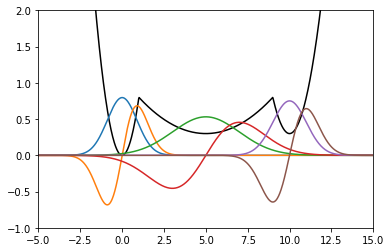

In [2]:
from transit_chem.basis import HarmonicOscillator, harmonic_basis_from_parabola

cutoff_energy = 2
basis = (
    harmonic_basis_from_parabola(triple_well.well1, cutoff_energy=cutoff_energy)[:2]
    + harmonic_basis_from_parabola(triple_well.well2, cutoff_energy=cutoff_energy)[:2]
    + harmonic_basis_from_parabola(triple_well.well3, cutoff_energy=cutoff_energy)[:2]
)

plt.plot(x, triple_well(x), "k")
for b in basis:
    plt.plot(x, b(x))
plt.xlim(*XLIM)
plt.ylim(*YLIM)  

In [3]:
from transit_chem import operators as op
from transit_chem.utils import pairwise_array_from_func

S = pairwise_array_from_func(basis, op.overlap, symmetric=True)
H = pairwise_array_from_func(basis, op.Hamiltonian(triple_well), symmetric=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:03<00:00,  5.56it/s]


(-1, 1)

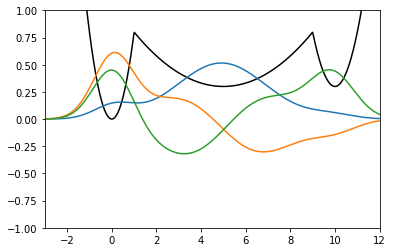

In [29]:
from transit_chem.basis import EigenBasis

eig_basis = EigenBasis.from_basis(basis, H, S)

plt.plot(x, triple_well(x), "k")
for b in eig_basis.states[:3]:
    plt.plot(x, b(x))

plt.xlim(-3, 12)
plt.ylim(-1, 1)

In [7]:
pairwise_array_from_func(eigenbasis, op.overlap, symmetric=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:09<00:00,  2.19it/s]


array([[ 1., -0.,  0., -0.,  0.,  0.],
       [-0.,  1.,  0.,  0., -0., -0.],
       [ 0.,  0.,  1.,  0., -0.,  0.],
       [-0.,  0.,  0.,  1., -0.,  0.],
       [ 0., -0., -0., -0.,  1., -0.],
       [ 0., -0.,  0.,  0., -0.,  1.]])

In [10]:
time_evolving = eig_basis.time_evolving(basis[0])

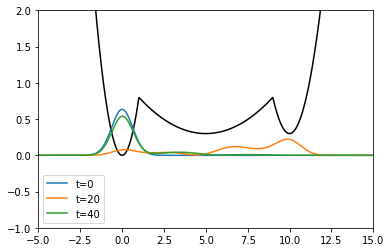

In [41]:
def density(x, t):
    wf = time_evolving(x, t)
    return np.real(wf * np.conj(wf))

fig = plt.figure()
plt.plot(x, triple_well(x), "k")
for t in range(0, 50, 20):
    plt.plot(x, density(x, t), label=f"t={t}")
    
plt.legend()
plt.xlim(*XLIM)
plt.ylim(*YLIM)
plt.show()